# Stochastic Gradient Descent (SGD)

**Stochastic Gradient Descent** is a form of gradient descent that allows us to update the Weights Matrix of our scoring function multiple times per epoch of our dataset.  This is accomplished by feeding the scoring function smaller batches of our dataset (as opposed to the entire training dataset).  We calculate the gradient of these smaller batches, adust our Weights Matrix and Bias Vector based on this smaller batch, and use these adjustments when feeding in the next batch.

Typical batch sizes include 32, 64, 128, and 256 (powers of 2 allow the optimization of linear algebra libraries... why?)

The benefits include faster training time, increased accuracy, and the reduction of variance in the parameter update (explain - more stable convergence).  We can sort of conceptualize this as combining loss landscapes in small chunks to bring the resolution of the total loss landscape into view.

The pseudo-code of this implementation would be:

                               while True:
                                   batch = next_training_batch(data,256)
                                   Wgradient = evaluate_gradient(loss, batch, W)
                                   W += -alpha * Wgradient

(Insert cool resolution image here).

SGD is implemented below, which appears almost identical to the implementation of GD.  Where these differ is noted.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import argparse

def sigmoid_activation(x):
    # compute the sigmoid activation value for a given input
    return 1.0 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    # copute the derivate of the sigmoid function ASSUMING
    # that the input 'x' has already been passed through the sigmoid
    # activation funciton
    return x*(1 - x)

def predict(X, W):
    # take the dot product between our features and weight matrix
    preds = sigmoid_activation(X.dot(W))
    
    # apply a step function to threshold the outputs to binary
    # class labels
    preds[preds <= 0.5] = 0
    preds[preds > 0] = 1
    
    # return the predictions
    return preds


# Adding next_batch Function

This function allows us segment our training data into batches so we can update our Weights Matrix multiple times per epoch.

In [28]:
# New function added for Stochastic Gradient Descent

def next_batch (X, y, batchSize):
    # loop over our dataset 'X' in mini-batchs, yielding a tuple of
    # the current batched data and labels
    
    # They yield keyword in Python returns a "generator object".  Basicaly, this object does not store all the
    # values in memory, it "generates" them on the fly.  So, when the function is called, it doesn't
    # actually run, it simply builds the generator object.  Then each time the generator obeject is looped through
    # it returns the next value in the generator.  You can only move through a generator once.
    
    # Generator objects (and hence the keyword "yield") are appropriate when you expect to have a ton of data
    # that you only need to move through once.  They return the next iterable in the object.
    
    for i in np.arange(0, X.shape[0], batchSize):
        yield (X[i:i + batchSize], y[i:i + batchSize])
        


# Adding batch-size Argument

Here we add a batch-size argment to our argument parser.  In practice the batch-size will roughly be proportional to the amount of data you can load into ram at a time.  If running on GPU's this becomes less important than running on a CPU (need to understand how to calculate appropriate batch size).  Typical batch sizes are factors of 2 (as mentioned above) to take advantage of optimization possible in linear algebra liabraries.

In [29]:
# Construct the argument parse and parse the arguments

ap = argparse.ArgumentParser()
ap.add_argument("-e", "--epochs", type=float, default=100, help="# of epochs")
ap.add_argument("-a", "--alpha", type=float, default=0.01, help="learning rate")

# Add argument for SGD
ap.add_argument("-b", "--batch-size", type=int, default=32, help="size of SGD mini-batches")

args = vars(ap.parse_args)

In [30]:
# Generate a 2-class classification problem with 1000 data points,
# where each data point is a 2D feature vector

(X, y) = make_blobs(n_samples=1000, n_features=2, centers = 2, cluster_std = 1.5, random_state=1)

# Reshpae y labels from a single array of 0's and 1's to a 1D np array column vector with 1000 rows, 
# each containing a single 0 or 1

y = y.reshape((y.shape[0],1))

# Insert a column of 1's as the last entry in the feature
# matrix -- this litter trick allows us to treat the bias
# as a trainable parameter within the weight matrix

# np.c_ appends np arrays together
# np.ones creates a 1 dimension np array of 1's

# The below function creates an np array of 1's the length of which is equal to the number of columns in X.
# It then appends these 1's to each Xi as an additional feature.  We're working towards the Bias Trick here.

X = np.c_[X, np.ones((X.shape[0]))]
(trainX, testX, trainY, testY) = train_test_split(X,y, test_size=0.5, random_state=42)

# Initialize the weights matrix with normally distributed numbers
# The amount of weights matrix rows should match the input data matrix columns
# and list of losses

print("[INFO]... Training")
W = np.random.randn(X.shape[1],1)
losses = []

[INFO]... Training


# Mini-Batch Updates

Here we see the heart of the Stochastic Gradient Descent change.  We nudge our Weights Matrix values based on the gradient found for each mini-batch of our dataset.  This allows us to update the Weights multiple times per epoch.  We averge the loss over all the mini-batches to retrieve the average loss per epoch.  This is later plotted.

In [31]:
# Loop for the desired number of Epochs
# Follow the variable types here...

args['epochs'] = 100
args['alpha'] = 0.01
args['batch-size'] = 32

for epoch in np.arange(0, args["epochs"]):
    # Initialize the total loss for the epoch
    epochLoss = []
    
    # Loop over our data in batches
    for (batchX, batchY) in next_batch(trainX, trainY, args["batch-size"]):
        # Take the dot product between our current batch of features 'X' and
        # our weight matrix 'W', then pass this value through
        # our sigmoid activation function, thereby giving us
        # our predictions on the dataset
        preds = sigmoid_activation(batchX.dot(W))
    
        # Now that we have our predictions, we need to determine
        # the 'error', which is the difference between our predictions
        # and the true values.
        error = preds - batchY
        batch_loss = np.sum(error ** 2)
        epochLoss.append(batch_loss)
    
        # The gradient descent update is the dot product between our (1) current
        # batch of features and (2) the error of the sigmoid derivate 
        # of our predictions
        d = error*sigmoid_deriv(preds)
        gradient = batchX.T.dot(d)
    
        # In the update state, all we need to do is "nudge" the Weight
        # matrix in the negative direction of the gradient (hence the
        # term "gradient descent" by taking a small step towards a set
        # of "more optimal" parameters)
        W += -args["alpha"] * gradient
    
    # update our loss history by taking the average loss across all batches
    loss = np.average(epochLoss)
    losses.append(loss)
    
    # Check to see if an update should be displayed
    if epoch == 0 or (epoch + 1) % 5 == 0:
        print("[INFO] epoch={}, loss={:.7f}".format(int(epoch+1),loss))

[INFO] epoch=1, loss=15.1613703
[INFO] epoch=5, loss=0.0663245
[INFO] epoch=10, loss=0.0321855
[INFO] epoch=15, loss=0.0291331
[INFO] epoch=20, loss=0.0280015
[INFO] epoch=25, loss=0.0273127
[INFO] epoch=30, loss=0.0267764
[INFO] epoch=35, loss=0.0263074
[INFO] epoch=40, loss=0.0258747
[INFO] epoch=45, loss=0.0254655
[INFO] epoch=50, loss=0.0250738
[INFO] epoch=55, loss=0.0246965
[INFO] epoch=60, loss=0.0243320
[INFO] epoch=65, loss=0.0239791
[INFO] epoch=70, loss=0.0236370
[INFO] epoch=75, loss=0.0233050
[INFO] epoch=80, loss=0.0229826
[INFO] epoch=85, loss=0.0226693
[INFO] epoch=90, loss=0.0223648
[INFO] epoch=95, loss=0.0220685
[INFO] epoch=100, loss=0.0217802


In [32]:
# evaluate our model
print("[INFO] evaluating...")
preds = predict(testX, W)
print(classification_report(testY, preds))

[INFO] evaluating...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       250

   micro avg       1.00      1.00      1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



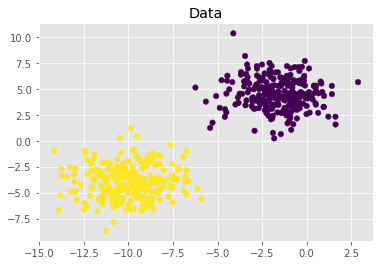

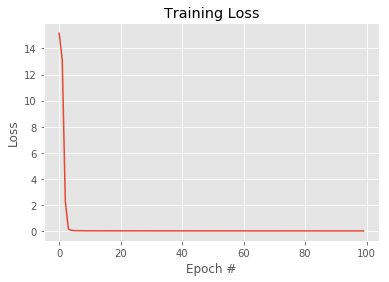

In [33]:
args["epochs"] = 100

# Plot the (testing) classification data
plt.style.use("ggplot")
plt.figure()
plt.title("Data")
plt.scatter(testX[:,0],testX[:,1], marker="o", c=testY[:,0], s=30)

# Construct a figure that plots the loss over time
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,args["epochs"]), losses)
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

# Evaluating the Model

If we compare our new **Stochastic Gradient Descent** model with our previous **Gradient Descent** model, we see we end up with an epoch loss of apprx .02 after 100 epochs as opposed to a loss of apprx. 0.26 after 100 epochs.  This is a huge improvement (and due to updating the Weights Matrix multiple times per epoch).